### **LIBRERIE**

This notebook has been tested also with one dropout less and with higher learning rate and different optimizers like Adam

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.xception import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import random
import os
import tensorflow as tf
from PIL import Image
import logging
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#**DATASET**

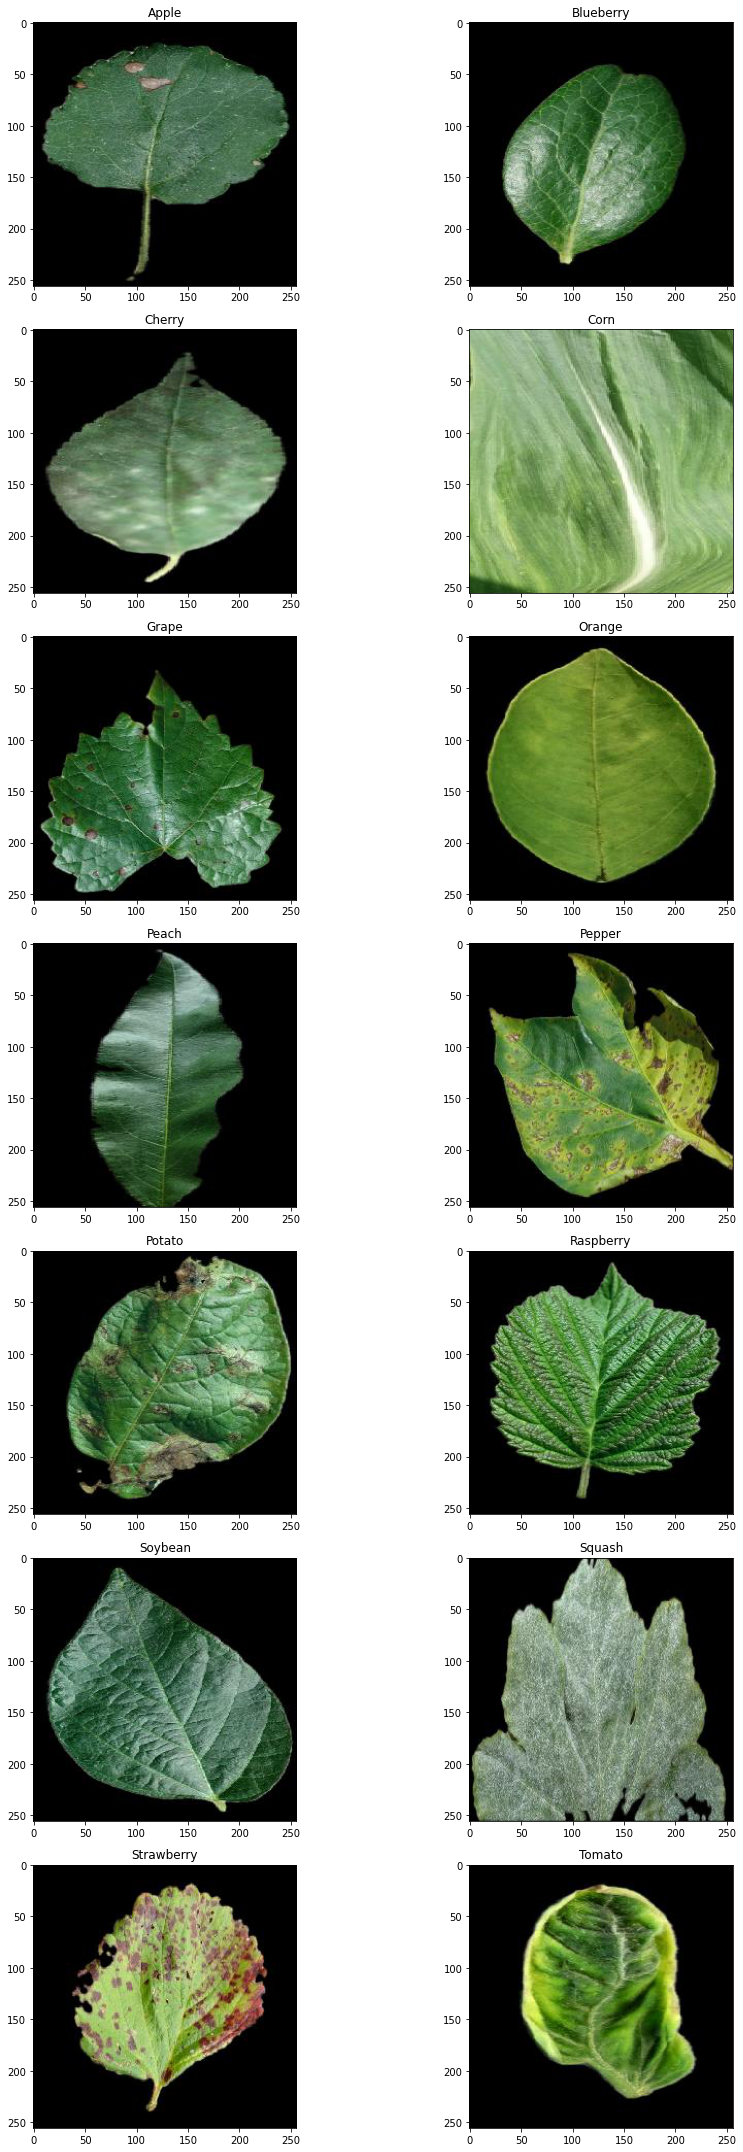

In [ ]:
dataset_dir = '../input/iperfoglie/leaves_overUnder_sampled_more'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test') 

# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Number of training images per category:')

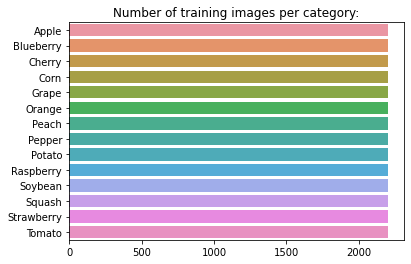

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

###**DATA AUGMENTATION**

In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=180,
                                        height_shift_range=150,
                                        width_shift_range=200,
                                        zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=False, 
                                        fill_mode='constant',
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. non worka con vgg16
                                        ) # rescale value is multiplied to the image
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(256,256),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             shuffle=False,
                                             seed=seed)

Found 30800 images belonging to 14 classes.
Found 14000 images belonging to 14 classes.
Found 1785 images belonging to 14 classes.


#**CALLBACKS**

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  callbacks = []
  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

# **Transfer learning**

In [ ]:
from tensorflow.keras import regularizers

tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')


base_model = tfk.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False
inputs = tfk.Input(shape=(256, 256, 3))
x = tf.keras.layers.Resizing( 299, 299, interpolation='bilinear', crop_to_aspect_ratio=True,) (inputs)
x = base_model(x, training=False)
x = tfk.layers.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=14, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)

tl_model = tfk.Model(inputs, output_layer)

tl_model.compile(optimizer=tfk.optimizers.Adam(0.0001),
              loss=tfk.losses.CategoricalCrossentropy(),
              metrics= 'accuracy')
tl_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
Flattening (Flatten)         (None, 204800)            0         
_________________________________________________________________
dropout (Dropout)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
______________________________________________________________

In [ ]:
# Train the model

tl_history = tl_model.fit(x = aug_train_gen, epochs=200, callbacks=tl_callbacks, validation_data=valid_gen)

Epoch 1/200
963/963 [==============================] - 530s 541ms/step - loss: 2.3407 - accuracy: 0.5610 - val_loss: 1.1067 - val_accuracy: 0.8834
Epoch 2/200
963/963 [==============================] - 474s 492ms/step - loss: 1.7354 - accuracy: 0.6612 - val_loss: 0.8915 - val_accuracy: 0.9183
Epoch 3/200
963/963 [==============================] - 467s 485ms/step - loss: 1.5598 - accuracy: 0.6904 - val_loss: 0.7962 - val_accuracy: 0.9260
Epoch 4/200
963/963 [==============================] - 440s 456ms/step - loss: 1.4984 - accuracy: 0.7022 - val_loss: 0.8221 - val_accuracy: 0.9129
Epoch 5/200
963/963 [==============================] - 444s 461ms/step - loss: 1.4824 - accuracy: 0.7103 - val_loss: 0.7621 - val_accuracy: 0.9454
Epoch 6/200
963/963 [==============================] - 453s 470ms/step - loss: 1.4587 - accuracy: 0.7210 - val_loss: 0.7885 - val_accuracy: 0.9401
Epoch 7/200
963/963 [==============================] - 446s 463ms/step - loss: 1.4355 - accuracy: 0.7319 - val_loss: 0

# Plot the training

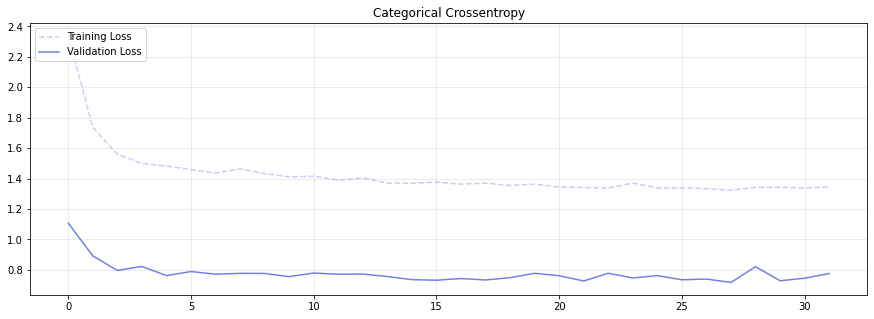

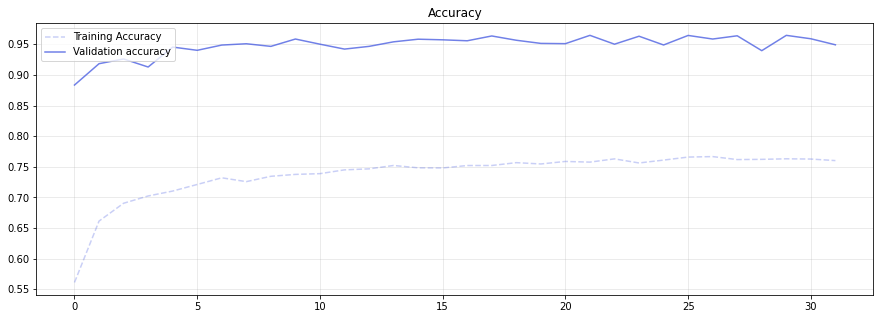

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(tl_history.history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history.history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history.history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the best model

In [ ]:
tl_model.save('TLSuperBalanced.h5')
#del tl_model  # To avoid filling the memory

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)




>TEST



In [ ]:
test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(test_metrics)

56/56 [==============================] - 12s 219ms/step - loss: 0.7743 - accuracy: 0.9473

Test metrics without data augmentation
{'loss': 0.774298369884491, 'accuracy': 0.9473389387130737}


## **FINE TUNING**

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TLSuperBalanced.h5')
ft_model.summary()
# Set all VGG layers to True
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 299, 299, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 10, 10, 2048)      20861480  
_________________________________________________________________
Flattening (Flatten)         (None, 204800)            0         
_________________________________________________________________
dropout (Dropout)            (None, 204800)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               52429056  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

In [ ]:
# Freeze first N layers
for i, layer in enumerate(ft_model.get_layer('xception').layers[:125]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d False
13 block2_pool False
14 batch_normalization False
15 add False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_1 False
23 block3_pool False
24 batch_normalization_1 False
25 add_1 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_2 False
33 block4_pool False
34 batch_normalization_2 False
35 add_2 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepconv2 False

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

# Fine-tune the model
ft_history = ft_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = tl_callbacks).history

Epoch 1/200
963/963 [==============================] - 485s 500ms/step - loss: 1.2196 - accuracy: 0.7890 - val_loss: 0.6695 - val_accuracy: 0.9766
Epoch 2/200
963/963 [==============================] - 477s 495ms/step - loss: 1.1059 - accuracy: 0.8298 - val_loss: 0.6395 - val_accuracy: 0.9866
Epoch 3/200
963/963 [==============================] - 466s 484ms/step - loss: 1.0510 - accuracy: 0.8472 - val_loss: 0.6714 - val_accuracy: 0.9717
Epoch 4/200
963/963 [==============================] - 465s 483ms/step - loss: 0.9897 - accuracy: 0.8612 - val_loss: 0.5961 - val_accuracy: 0.9854
Epoch 5/200
963/963 [==============================] - 463s 481ms/step - loss: 0.9551 - accuracy: 0.8664 - val_loss: 0.5748 - val_accuracy: 0.9830
Epoch 6/200
963/963 [==============================] - 470s 489ms/step - loss: 0.8999 - accuracy: 0.8746 - val_loss: 0.5288 - val_accuracy: 0.9909
Epoch 7/200
963/963 [==============================] - 461s 479ms/step - loss: 0.8378 - accuracy: 0.8808 - val_loss: 0

In [ ]:
#Save the best model
ft_model.save('FTSuperBalanced.h5')
#del tl_model  # To avoid filling the memory



In [ ]:
ft_test_metrics = ft_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(ft_test_metrics)

56/56 [==============================] - 8s 145ms/step - loss: 0.2918 - accuracy: 0.9888

Test metrics without data augmentation
{'loss': 0.29180464148521423, 'accuracy': 0.9887955188751221}


In [ ]:
print(f"val_acc:{max(ft_history['val_accuracy'])} val_loss: {min(ft_history['val_loss'])}")
print(f"train_acc:{max(ft_history['accuracy'])} train_loss: {min(ft_history['loss'])}")

val_acc:0.9957143068313599 val_loss: 0.21026936173439026
train_acc:0.9124675393104553 train_loss: 0.4616895020008087
